# Simulating Spectra

Through DESI's specsim we will simulate mock spectra with FOBOS parameters

First we have to double check that our environment is setup. In your command line you should type out something along the lines of export DESIMODEL=/{.../desimodel} where ... is the path to the desimodel package. 

In [1]:
import os
def check_env():
    for env in ('DESIMODEL',):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))
check_env()

DESIMODEL environment set to /users/richardp/research/fobos/desi/desimodel


# Introduction

The first step we did was to check that the code to generate smoothed objects and their Mini-IFUs worked. Now we will use those magnitudes calculated to renormalize specsim spectra. 

In [2]:
cd /Users/RichardP/Research/FOBOS/py_FOBOS/

/Users/RichardP/research/fobos/py_FOBOS


In [3]:
import numpy as np
from astropy.io import fits
from astropy import wcs
import matplotlib.pyplot as plt
import scipy.ndimage.filters as ndimage
#This is the specific code
import fobos_sim

In [4]:
gen = fobos_sim.fobos_sim('/Users/RichardP/Research/FOBOS/Samples/acs_I_030mas_088_sci.fits', .57, 7)
gen.catalog_info('/Users/RichardP/Research/FOBOS/Samples/photoz_vers2.0_010312_UltraVISTA2016.fits')

First, we are going to look for a specific object with IMAG between 23 - 24 and save them into a list for specsim later. These objects will be the magnitude objects we use to renormalize.

In [5]:
gen.target_indexes = []
def sample_index():
    counter = 0
    for i in range(0, len(gen.objects_index)):
        if counter <= 70:
            if gen.objects_Imag[i] > 23 and gen.objects_Imag[i] < 24:
                #print(str(gen.objects_id[i]) + "_" + str(i) + ": " + str(gen.objects_Imag[i]))
                gen.target_indexes.append(i)
                counter += 1
sample_index()


## Smoothing

We will start by doing our basic Mini-IFU overplotting and then smoothing with FWHM = .7. We guess that the seeing will be around .7 and can change that value to more extreme seeing conditions. This is needed because of the inherent seeing caused by the atmosphere. 

In [6]:
gen.overplotting()

In [7]:
FWHM = .7
gen.smooth(FWHM)
gen.smoothing(FWHM)

Now we will run a simple script to convert the smoothed fluxes to magnitudes and compile into lists according to their Mini-IFU's. This will organize us for the next step when we want to renormalize the spectra

In [8]:
gen.mag_organization()

/Users/RichardP/research/fobos/py_FOBOS/fobos_sim.py:353: RuntimeWarning: invalid value encountered in log10
  ABMAG =  ((-2.5 * np.log10(FluxVals[i])) +23.9)


In [9]:
print(len(gen.Mag0))
print(len(gen.Mag1))
print(len(gen.Mag2))
print(len(gen.Mag3))
print(len(gen.Mag4))
print(len(gen.Mag5))
print(len(gen.Mag6))

71
71
71
71
71
71
71


Sanity check we have 71 magnitudes for each Mini-IFU totaling to 497 total fibers. We will now begin to incorporate specsim.

## Setting Up Specsim

We have our magnitudes for the Mini-IFUs and now we just need our mock spectra.

Here is link for the doc instructing on setting up specsim. 

https://www.evernote.com/l/Ar1Rsj1ZwFpM77nrwimGqa3bSIDhqMb039M

Now desi.yaml should be set. The import parameters for desi.yaml is the primary diameter and obscuration diameter as it sets up the instrument. All the other information is "technically" pertinent to FOBOS such as atmosphere and source. However, the source input parameters such as z_in and z_out we can and will edit in this notebook.

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np

We will now import the simulator. If you have not done so already download specsim in your environment <br>
<b>$pip install specsim<b>

In [12]:
import specsim.simulator

We want to generate 71 spectra each with 7 fibers. This is to represent 7 Mini-IFUs multiplied by 71 total objects. We will assume that the redshift of these objects are random between redshift 2 and redshift 3 so we can differentiate between spectra. The input parameters for this method is gen.gen_spectra(yaml path, number of fibers, number of  spectra, redshift input, redshift output, abmag output

In [13]:
gen.gen_spectra('/users/richardp/research/fobos/desi/specsim/specsim/data/config/fobos.yaml', 7, 1, 0, 2.5, 23)

/Users/RichardP/anaconda3/envs/plue/lib/python3.5/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


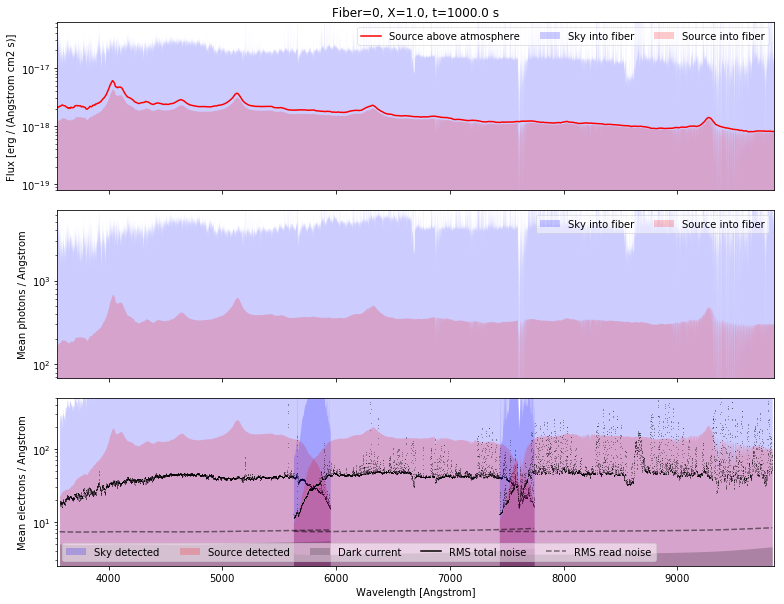

In [17]:
gen.fobos['0'].plot()
gen.fobos['20'].plot()
gen.fobos['32'].plot()

We have set up a dictionary called fobos with 71 different spectra that have random redshift. We have normalized about abmag 23, but we will renormalize according to the magnitude values calculated earlier. 

Now we want to renormalize the values. gen_spec has a method to do this renormalization for us. 

In [ ]:
def mag_normalization(Mini_IFU_list, original_mag, IFU_number):
    for i in range(0,1):
        for j in range(0,63001):
            gen.renormalization(Mini_IFU_list[i], original_mag, float(gen.fobos[str(i)].simulated["source_flux"][j][IFU_number]))
            gen.fobos[str(i)].simulated["source_flux"][j][IFU_number] = gen.flux1val
mag_normalization(gen.Mag0, 23, 0)
mag_normalization(gen.Mag1, 23, 1)
mag_normalization(gen.Mag2, 23, 2)
mag_normalization(gen.Mag3, 23, 3)
mag_normalization(gen.Mag4, 23, 4)
mag_normalization(gen.Mag5, 23, 5)
mag_normalization(gen.Mag6, 23, 6)

We have now renormalized the spectra for each fiber according to the Mini-IFU counter part. To do this we indexed through every fobos wavelength and renormalized the spectra according to the Mini-IFU counterpart. 

# Different Seeing

We will now rerun the code with different FWHM to see the impact.

In [ ]:
FWHM = 1.0
gen.smooth(FWHM)
gen.smoothing(FWHM)
gen.mag_organization()
gen.gen_spectra('/users/richardp/research/fobos/desi/specsim/specsim/data/config/fobos.yaml', 7, 71, 0, 2.5, 23)
gen.fobos['1'].plot()
gen.fobos['20'].plot()
gen.fobos['32'].plot()

In [ ]:
mag_normalization(gen.Mag0, 23, 0)
mag_normalization(gen.Mag1, 23, 1)
mag_normalization(gen.Mag2, 23, 2)
mag_normalization(gen.Mag3, 23, 3)
mag_normalization(gen.Mag4, 23, 4)
mag_normalization(gen.Mag5, 23, 5)
mag_normalization(gen.Mag6, 23, 6)
gen.fobos['1'].plot()
gen.fobos['20'].plot()
gen.fobos['32'].plot()

In [ ]:
print(gen.fobos['1'].simulated["source_flux"][0])

## Generating a Noisy Spectra

So we have some sort of spectra plotted, but now we want to generate a noisy spectra. To do this we will add source flux to a random number from a gaussian distribution with sigma as the RMS total noise. 

In [49]:
gen.fobos['0'].observation.exposure_time

<Quantity 1000.0 s>

In [39]:
gen.fobos['0'].camera_output[0]['variance_electrons']

183.122783999 .. 183.122783999
183.281573791 .. 183.281573791
182.781913977 .. 182.781913977
177.756797489 .. 177.756797489
162.63471753 .. 162.63471753
143.443715944 .. 143.443715944
133.563879296 .. 133.563879296
139.523374489 .. 139.523374489
154.494014357 .. 154.494014357
164.044525123 .. 164.044525123
161.368714439 .. 161.368714439


Now we will plot out 7 noisy spectra to mimic what a FOBOS noisy spectra would look like. This is because we will utilize 7 Mini-IFUs per object and so this will indicate how the 7 Mini-IFUs look with the noisy spectra of the object. (**In Progress**)

In [46]:
gen.fobos['0'].atmosphere.airmass

1.0